# Deep Learning for Time Series (Chollet Book)

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

# Read in Data

Data collected is from 2023 to current.

In [3]:
df = pd.read_csv("mpi_roof.csv", encoding= 'unicode_escape')

f = open('mpi_roof.csv', encoding= 'unicode_escape')
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

#df.head()

# Inspecting the Data

In [4]:
# print(df.columns)
# print("\n\n")
# print("Shape of data: ", df.shape)

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"', '"rain (mm)"', '"raining (s)"', '"SWDR (W/m²)"', '"PAR (µmol/m²/s)"', '"max. PAR (µmol/m²/s)"', '"Tlog (degC)"', '"CO2 (ppm)"']
16587


# Parsing the Data

In [5]:
# convert all columns to float except date column

df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').astype(float)

# convert date to datetime object (date frequency is 10 minutes)

df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = np.array([float(x) for x in line.split(',')[1:]])
    if values.shape == (len(header) - 1,):
        float_data[i, :] = values
    else:
        print(f"Skipping line {i+1} due to incorrect shape of values")

Skipping line 16587 due to incorrect shape of values


# Plotting the temperature timeseries

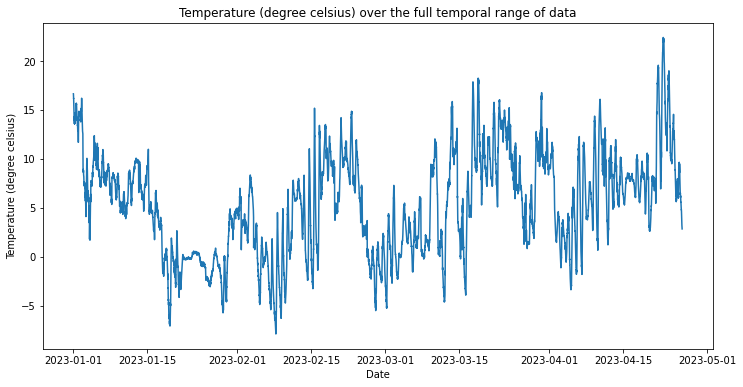

In [6]:
plt.figure(figsize=(12, 6))  # Set the width to 12 inches and height to 6 inches
plt.plot(df['Date Time'], df['T (degC)']) # x, y encoding
plt.title("Temperature (degree celsius) over the full temporal range of data") # title
plt.xlabel("Date") # x-axis label
plt.ylabel("Temperature (degree celsius)") # y-axis label
plt.show()

# Plotting the first 10 days of the temperature timeseries

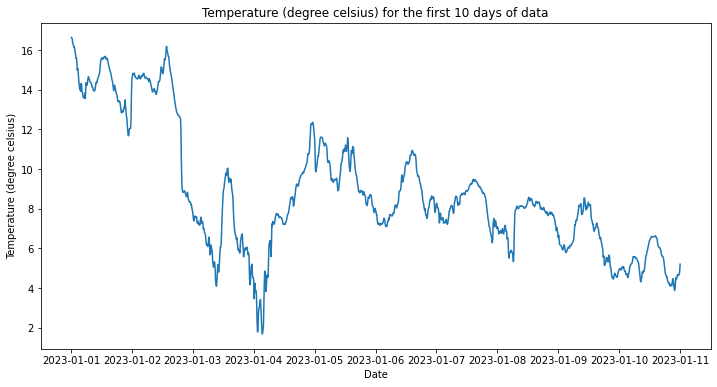

In [7]:
plt.figure(figsize=(12, 6))  # Set the width to 12 inches and height to 6 inches
plt.plot(df['Date Time'][0:1440,], df['T (degC)'][0:1440,]) # x, y encoding
plt.title("Temperature (degree celsius) for the first 10 days of data") # title
plt.xlabel("Date") # x-axis label
plt.ylabel("Temperature (degree celsius)") # y-axis label
plt.show()

# Normalizing the data

Preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. I am going to use the first 8,000 timesteps as training data,
so compute the mean and standard deviation only on this fraction of the data.

In [8]:
# get only numeric cols

#float_data = df.iloc[:, 2] # subset only temp data

# convert to numpy array
#float_data = float_data.to_numpy()

mean = float_data[:8000].mean(axis=0)
float_data -= mean
std = float_data[:8000].std(axis=0)
float_data /= std

# Generator yielding timeseries samples and their targets

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

lookback = 1440 # observations go back 10 days
step = 6 # Observations will be sampled at one data point per hour.
delay = 144 # Targets will be 24 hours in the future.
batch_size = 128 # Number of samples per batch

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay, 
                      min_index=0, # We will only draw from the first 200,000 timesteps
                      max_index=8000, # We will use the first 8000 timesteps as training data
                      shuffle=True, # Shuffle the samples
                      step=step, 
                      batch_size=batch_size)

val_gen = generator(float_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=8001,
                    max_index=12000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=10001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# How many steps to draw from val_gen in order to see the entire validation set

val_steps = (10000 - 8001 - lookback) // batch_size

# How many steps to draw from test_gen in order to see the entire test set

test_steps = (len(float_data) - 10001 - lookback) // batch_size

# Computing the common-sense baseline MAE

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

1.1648540583281701


# Training and evaluating a densely connected model

In [11]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 7s 14ms/step - loss: 3.3082 - mae: 1.0409 - val_loss: 6.9385 - val_mae: 2.3070
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.5480 - mae: 0.4810 - val_loss: 8.7483 - val_mae: 2.4272
Epoch 3/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1636 - mae: 0.2631 - val_loss: 3.1957 - val_mae: 1.3233
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.0491 - mae: 0.1479 - val_loss: 0.9195 - val_mae: 0.7544
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.0174 - mae: 0.0923 - val_loss: 1.7029 - val_mae: 1.1284
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.0091 - mae: 0.0695 - val_loss: 2.8960 - val_mae: 1.4790
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.0067 - mae: 0.0608 - val_loss: 5.3124 - val_mae: 

# Plotting results

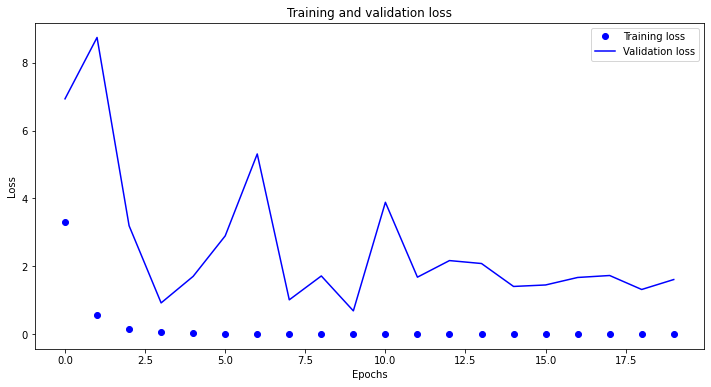

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(12, 6))  # Set the width to 12 inches and height to 6 inches
plt.plot(epochs, loss, 'bo', label='Training loss') # x, y encoding
plt.plot(epochs, val_loss, 'b', label='Validation loss') # x, y encoding
plt.title('Training and validation loss') # title
plt.xlabel('Epochs') # x-axis label
plt.ylabel('Loss') # y-axis label
plt.legend()
plt.show()

Overfitting!

# Training and evaluating a GRU-based model

Epoch 1/20
500/500 [==============================] - 61s 123ms/step - loss: 0.1485 - mae: 0.2777 - val_loss: 1.0006 - val_mae: 0.8600
Epoch 2/20
500/500 [==============================] - 61s 121ms/step - loss: 0.0277 - mae: 0.1301 - val_loss: 1.5026 - val_mae: 1.0886
Epoch 3/20
500/500 [==============================] - 57s 113ms/step - loss: 0.0166 - mae: 0.0997 - val_loss: 0.8750 - val_mae: 0.7611
Epoch 4/20
500/500 [==============================] - 57s 114ms/step - loss: 0.0121 - mae: 0.0847 - val_loss: 1.3220 - val_mae: 1.1111
Epoch 5/20
500/500 [==============================] - 57s 114ms/step - loss: 0.0096 - mae: 0.0750 - val_loss: 1.0648 - val_mae: 0.8729
Epoch 6/20
500/500 [==============================] - 58s 115ms/step - loss: 0.0083 - mae: 0.0690 - val_loss: 0.7429 - val_mae: 0.7447
Epoch 7/20
500/500 [==============================] - 57s 114ms/step - loss: 0.0071 - mae: 0.0639 - val_loss: 0.8406 - val_mae: 0.7088
Epoch 8/20
500/500 [==============================] - 5

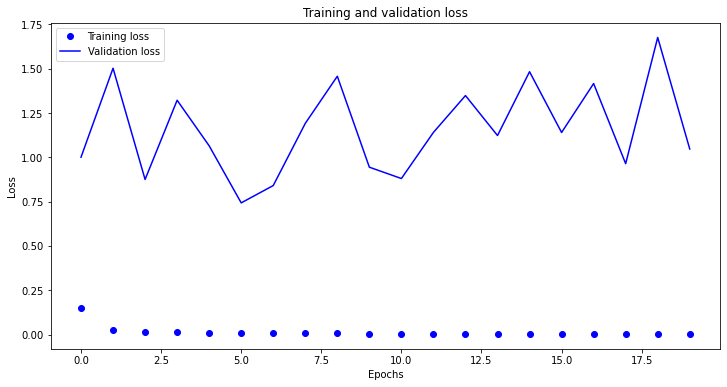

In [18]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(12, 6))  # Set the width to 12 inches and height to 6 inches
plt.plot(epochs, loss, 'bo', label='Training loss') # x, y encoding
plt.plot(epochs, val_loss, 'b', label='Validation loss') # x, y encoding
plt.title('Training and validation loss') # title
plt.xlabel('Epochs') # x-axis label
plt.ylabel('Loss') # y-axis label
plt.legend()
plt.show()

# Training and evaluating a dropout-regularized GRU-based model

Epoch 1/40
500/500 [==============================] - 98s 197ms/step - loss: 0.1813 - mae: 0.3224 - val_loss: 1.6950 - val_mae: 1.1441
Epoch 2/40
500/500 [==============================] - 99s 198ms/step - loss: 0.0611 - mae: 0.1933 - val_loss: 1.1202 - val_mae: 0.8083
Epoch 3/40
500/500 [==============================] - 96s 191ms/step - loss: 0.0395 - mae: 0.1555 - val_loss: 0.7581 - val_mae: 0.7379
Epoch 4/40
500/500 [==============================] - 98s 196ms/step - loss: 0.0298 - mae: 0.1344 - val_loss: 1.2269 - val_mae: 0.8905
Epoch 5/40
500/500 [==============================] - 96s 193ms/step - loss: 0.0244 - mae: 0.1215 - val_loss: 0.9458 - val_mae: 0.7802
Epoch 6/40
500/500 [==============================] - 97s 194ms/step - loss: 0.0209 - mae: 0.1119 - val_loss: 0.8450 - val_mae: 0.5979
Epoch 7/40
500/500 [==============================] - 99s 198ms/step - loss: 0.0184 - mae: 0.1042 - val_loss: 0.7478 - val_mae: 0.7290
Epoch 8/40
500/500 [==============================] - 1

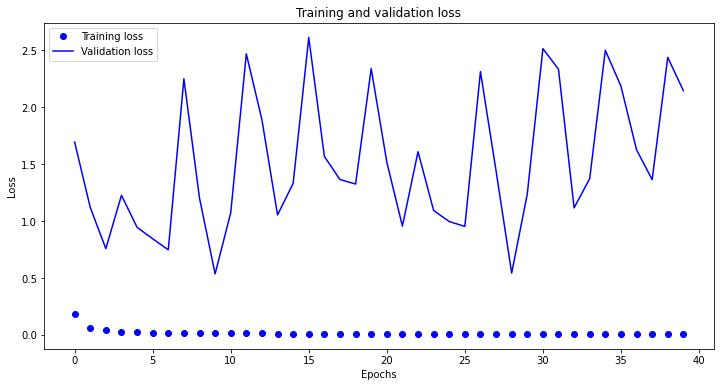

In [19]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(12, 6))  # Set the width to 12 inches and height to 6 inches

plt.plot(epochs, loss, 'bo', label='Training loss') # x, y encoding
plt.plot(epochs, val_loss, 'b', label='Validation loss') # x, y encoding
plt.title('Training and validation loss') # title
plt.xlabel('Epochs') # x-axis label
plt.ylabel('Loss') # y-axis label
plt.legend()

plt.show()

In [20]:
np.__version__

'1.18.5'

In [16]:
pd.__version__

'1.0.5'

In [17]:
tf.__version__

'2.3.0'

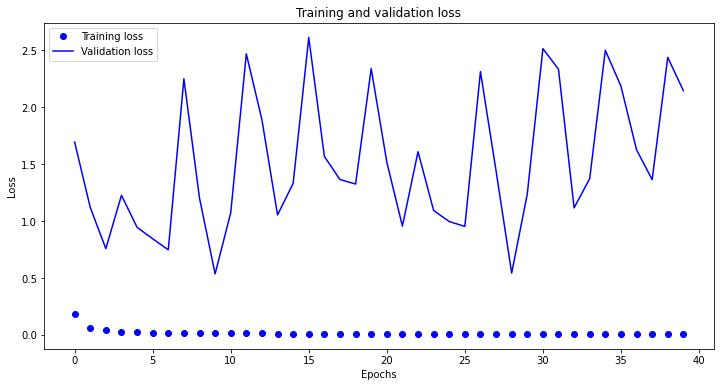

In [21]:
plt.figure(figsize=(12, 6))  # Set the width to 12 inches and height to 6 inches

plt.plot(epochs, loss, 'bo', label='Training loss') # x, y encoding
plt.plot(epochs, val_loss, 'b', label='Validation loss') # x, y encoding
plt.title('Training and validation loss') # title
plt.xlabel('Epochs') # x-axis label
plt.ylabel('Loss') # y-axis label
plt.legend()

plt.show()

# Training and evaluating a dropout-regularized, stacked GRU model

Epoch 1/20
100/100 [==============================] - 53s 525ms/step - loss: 0.2816 - mae: 0.4151 - val_loss: 0.4194 - val_mae: 0.5361
Epoch 2/20
100/100 [==============================] - 50s 496ms/step - loss: 0.1417 - mae: 0.2975 - val_loss: 0.8372 - val_mae: 0.7590
Epoch 3/20
100/100 [==============================] - 47s 469ms/step - loss: 0.0932 - mae: 0.2411 - val_loss: 0.6143 - val_mae: 0.6953
Epoch 4/20
100/100 [==============================] - 48s 483ms/step - loss: 0.0662 - mae: 0.2029 - val_loss: 1.1028 - val_mae: 0.8367
Epoch 5/20
100/100 [==============================] - 53s 533ms/step - loss: 0.0526 - mae: 0.1798 - val_loss: 0.5868 - val_mae: 0.6374
Epoch 6/20
100/100 [==============================] - 46s 464ms/step - loss: 0.0439 - mae: 0.1653 - val_loss: 1.9691 - val_mae: 1.0835
Epoch 7/20
100/100 [==============================] - 53s 530ms/step - loss: 0.0391 - mae: 0.1540 - val_loss: 1.3701 - val_mae: 0.9941
Epoch 8/20
100/100 [==============================] - 4

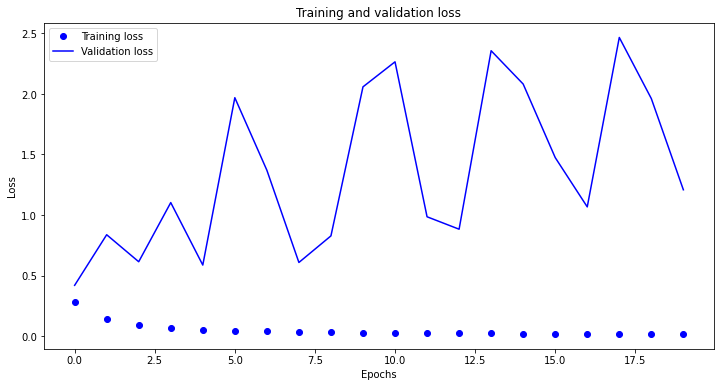

In [22]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                      dropout=0.1,
                      recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(12, 6))  # Set the width to 12 inches and height to 6 inches
plt.plot(epochs, loss, 'bo', label='Training loss') # x, y encoding
plt.plot(epochs, val_loss, 'b', label='Validation loss') # x, y encoding
plt.title('Training and validation loss') # title
plt.xlabel('Epochs') # x-axis label
plt.ylabel('Loss') # y-axis label
plt.legend()
plt.show()

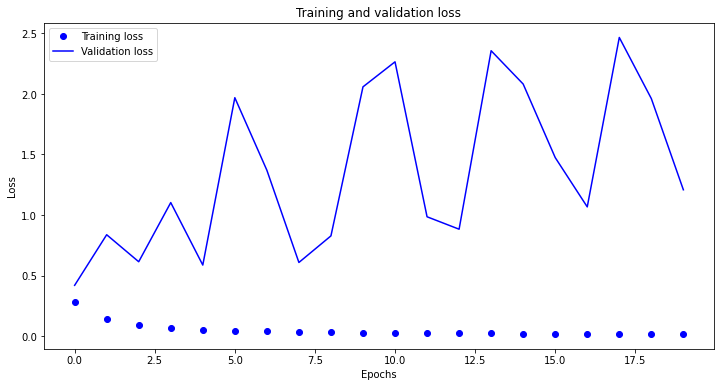

In [23]:
plt.figure(figsize=(12, 6))  # Set the width to 12 inches and height to 6 inches
plt.plot(epochs, loss, 'bo', label='Training loss') # x, y encoding
plt.plot(epochs, val_loss, 'b', label='Validation loss') # x, y encoding
plt.title('Training and validation loss') # title
plt.xlabel('Epochs') # x-axis label
plt.ylabel('Loss') # y-axis label
plt.legend()
plt.show()

# Using bidirectional RNNs

## Training and evaluating an LSTM using reversed sequences

In [24]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000  # Number of words to consider as features
maxlen = 500  # Cuts off texts after this many words (among the max_features most common words)

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

17465344/17464789 [==============================] - 1s 0us/step
Epoch 1/10
157/157 [==============================] - 66s 423ms/step - loss: 0.4896 - acc: 0.7682 - val_loss: 0.3528 - val_acc: 0.8634
Epoch 2/10
157/157 [==============================] - 65s 412ms/step - loss: 0.3077 - acc: 0.8812 - val_loss: 0.4862 - val_acc: 0.8274
Epoch 3/10
157/157 [==============================] - 74s 469ms/step - loss: 0.2571 - acc: 0.9026 - val_loss: 0.3685 - val_acc: 0.8690
Epoch 4/10
157/157 [==============================] - 72s 459ms/step - loss: 0.2151 - acc: 0.9238 - val_loss: 0.3472 - val_acc: 0.8550
Epoch 5/10
157/157 [==============================] - 64s 408ms/step - loss: 0.1919 - acc: 0.9307 - val_loss: 0.3919 - val_acc: 0.8654
Epoch 6/10
157/157 [==============================] - 68s 431ms/step - loss: 0.1654 - acc: 0.9418 - val_loss: 0.5138 - val_acc: 0.8206
Epoch 7/10
157/157 [==============================] - 77s 490ms/step - loss: 0.1516 - acc: 0.9465 - val_loss: 0.4064 - val_ac

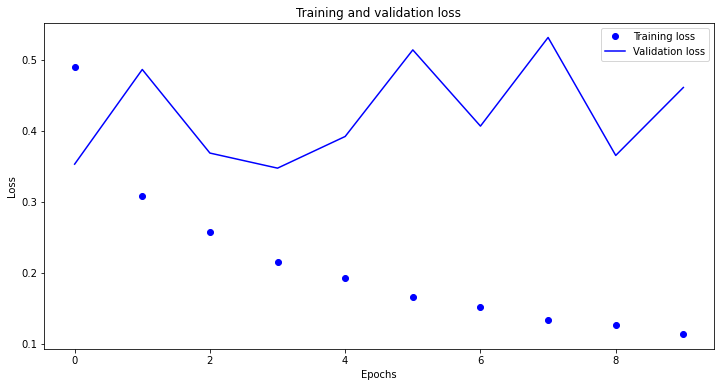

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(12, 6))  # Set the width to 12 inches and height to 6 inches
plt.plot(epochs, loss, 'bo', label='Training loss') # x, y encoding
plt.plot(epochs, val_loss, 'b', label='Validation loss') # x, y encoding
plt.title('Training and validation loss') # title
plt.xlabel('Epochs') # x-axis label
plt.ylabel('Loss') # y-axis label
plt.legend()
plt.show()

## Training and evaluating a bidirectional LSTM


In [26]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 61s 388ms/step - loss: 0.5537 - acc: 0.7210 - val_loss: 0.3970 - val_acc: 0.8318
Epoch 2/10
157/157 [==============================] - 61s 391ms/step - loss: 0.3350 - acc: 0.8752 - val_loss: 0.3272 - val_acc: 0.8706
Epoch 3/10
157/157 [==============================] - 64s 407ms/step - loss: 0.2660 - acc: 0.9024 - val_loss: 0.3795 - val_acc: 0.8310
Epoch 4/10
157/157 [==============================] - 71s 450ms/step - loss: 0.2255 - acc: 0.9212 - val_loss: 0.2973 - val_acc: 0.8902
Epoch 5/10
157/157 [==============================] - 59s 373ms/step - loss: 0.2013 - acc: 0.9294 - val_loss: 0.3334 - val_acc: 0.8762
Epoch 6/10
157/157 [==============================] - 67s 427ms/step - loss: 0.1794 - acc: 0.9352 - val_loss: 0.3464 - val_acc: 0.8752
Epoch 7/10
157/157 [==============================] - 61s 386ms/step - loss: 0.1588 - acc: 0.9454 - val_loss: 0.3267 - val_acc: 0.8872
Epoch 8/10
157/157 [==============================] - 6

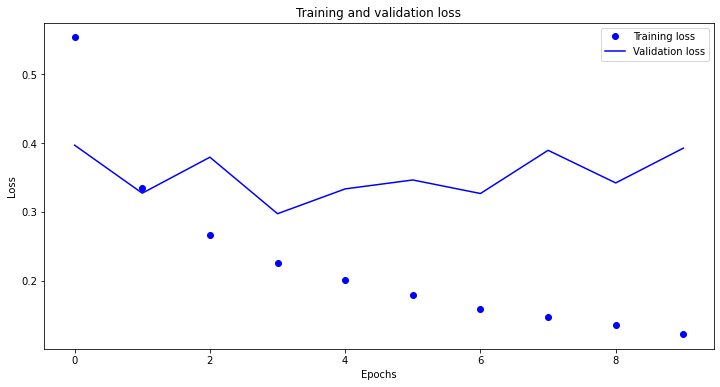

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(12, 6))  # Set the width to 12 inches and height to 6 inches
plt.plot(epochs, loss, 'bo', label='Training loss') # x, y encoding
plt.plot(epochs, val_loss, 'b', label='Validation loss') # x, y encoding
plt.title('Training and validation loss') # title
plt.xlabel('Epochs') # x-axis label
plt.ylabel('Loss') # y-axis label
plt.legend()
plt.show()

## Training a bidirectional GRU


In [28]:
model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
100/100 [==============================] - 15s 154ms/step - loss: 0.4185 - val_loss: 1.1352
Epoch 2/20
100/100 [==============================] - 15s 147ms/step - loss: 0.2504 - val_loss: 1.1510
Epoch 3/20
100/100 [==============================] - 15s 147ms/step - loss: 0.1914 - val_loss: 1.5312
Epoch 4/20
100/100 [==============================] - 15s 148ms/step - loss: 0.1641 - val_loss: 1.2938
Epoch 5/20
100/100 [==============================] - 15s 148ms/step - loss: 0.1452 - val_loss: 1.2898
Epoch 6/20
100/100 [==============================] - 15s 148ms/step - loss: 0.1328 - val_loss: 0.9555
Epoch 7/20
100/100 [==============================] - 15s 148ms/step - loss: 0.1227 - val_loss: 1.3906
Epoch 8/20
100/100 [==============================] - 15s 147ms/step - loss: 0.1146 - val_loss: 1.2216
Epoch 9/20
100/100 [==============================] - 15s 146ms/step - loss: 0.1088 - val_loss: 1.5388
Epoch 10/20
100/100 [==============================] - 15s 146ms/step - l

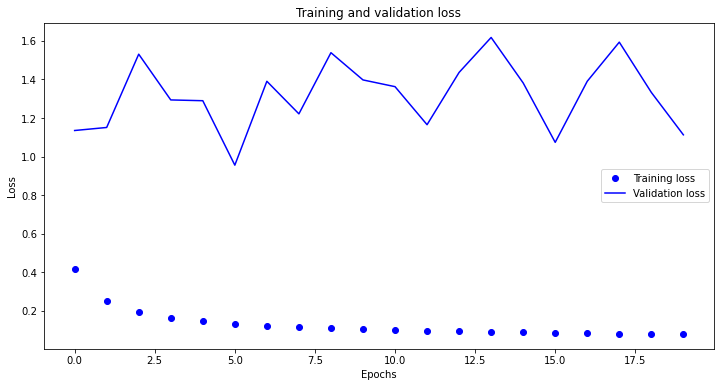

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(12, 6))  # Set the width to 12 inches and height to 6 inches
plt.plot(epochs, loss, 'bo', label='Training loss') # x, y encoding
plt.plot(epochs, val_loss, 'b', label='Validation loss') # x, y encoding
plt.title('Training and validation loss') # title
plt.xlabel('Epochs') # x-axis label
plt.ylabel('Loss') # y-axis label
plt.legend()
plt.show()